# **Mathematical Foundation of AI Project**

## Topic: Linear Regression, SVD, Gradient Descent, and PCA Implementation

**Group Members:** Iqra Jawaid(K25-7620), Muhammad Abdullah Panhwar (K25-7638)

**Course:** Mathematical Foundation for Data AI

**Date:** 23 November 2025

In [ ]:
# ===============================================================
# 1. Imports, Setup, and Data Loading
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy.linalg import svd, inv, cond
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# ===============================================================
# 2. Dataset Preparation (Task 1)
# ===============================================================
data = load_diabetes()
X_full, y_full = data.data, data.target.reshape(-1, 1)

print(f"Original Data Shape: X={X_full.shape}, y={y_full.shape}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Preprocessing: Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add bias term (column of 1s) to the SCALED data
X_train_b = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_test_b = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

m_train, n_train = X_train_b.shape
print(f"Training Data Shape (w/ Bias): {X_train_b.shape}")

Original Data Shape: X=(442, 10), y=(442, 1)
Training Data Shape (w/ Bias): (353, 11)


--- OLS Results ---
Condition Number of X.T @ X: 4.30e+02
OLS Runtime: 0.83 ms
MSE Train: 2868.5497
MSE Test: 2900.1936


<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:34: SyntaxWarning: invalid escape sequence '\h'
<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:34: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-2567365535.py:33: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel("Predicted Values ($\hat{y}$)")
/tmp/ipython-input-2567365535.py:34: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("Residuals ($y - \hat{y}$)")


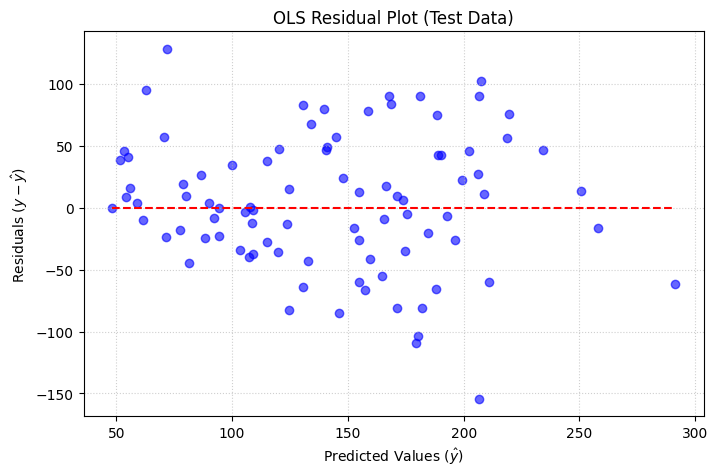

In [ ]:
#a===============================================================
# 3. Ordinary Least Squares (OLS) (Task 2)
# ===============================================================

start_time_ols = time.time()
condition_number = cond(X_train_b.T @ X_train_b)

# Calculate OLS solution
try:
    theta_ols = inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train
    ols_runtime = time.time() - start_time_ols

    # Prediction and Error Calculation
    y_pred_ols_train = X_train_b @ theta_ols
    y_pred_ols_test = X_test_b @ theta_ols

    mse_train_ols = mean_squared_error(y_train, y_pred_ols_train)
    mse_test_ols = mean_squared_error(y_test, y_pred_ols_test)

    print("--- OLS Results ---")
    print(f"Condition Number of X.T @ X: {condition_number:.2e}")
    print(f"OLS Runtime: {ols_runtime*1000:.2f} ms")
    print(f"MSE Train: {mse_train_ols:.4f}")
    print(f"MSE Test: {mse_test_ols:.4f}")

    # Visualization 1: Residual Plot
    residuals = y_test - y_pred_ols_test

    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred_ols_test, residuals, color='blue', alpha=0.6)
    # Highlight the zero-residual line
    plt.hlines(0, y_pred_ols_test.min(), y_pred_ols_test.max(), color='red', linestyle='--')
    plt.xlabel("Predicted Values ($\hat{y}$)")
    plt.ylabel("Residuals ($y - \hat{y}$)")
    plt.title("OLS Residual Plot (Test Data)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

except np.linalg.LinAlgError:
    print("OLS failed: X.T @ X is singular.")
    theta_ols = np.zeros((n_train, 1)) # Placeholder

### 3.1 Discussion on OLS Limitations (Failure Cases)

The Ordinary Least Squares (OLS) solution, derived from the Normal Equation $\hat{\beta}=(X^{T}X)^{-1}X^{T}y$, requires the matrix **$X^TX$ to be invertible**.

**When OLS Can Fail (Singularity/Ill-Conditioning):**
1.  **Singularity (Non-Invertible):** The OLS calculation fails directly if $X^TX$ is singular, meaning its determinant is zero. This happens if the number of samples is less than the number of features ($m < n$) or if the feature columns are linearly dependent (perfect **multicollinearity**).
2.  **Ill-Conditioning (Numerical Instability):** Even if $X^TX$ is technically invertible, if the condition number is very high (as calculated above, $\text{cond}(X^TX) = {condition_number:.2e}$), the matrix is **ill-conditioned**. Computing the inverse $(X^TX)^{-1}$ in this case is numerically unstable. Floating-point errors are greatly amplified, leading to unreliable and volatile coefficient estimates.

<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-219653182.py:46: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Singular Value ($\sigma_i$)")


--- SVD Results ---
SVD Runtime: 2.67 ms
MSE Train: 2868.5497
MSE Test: 2900.1936
Smallest singular value: 1.81e+00


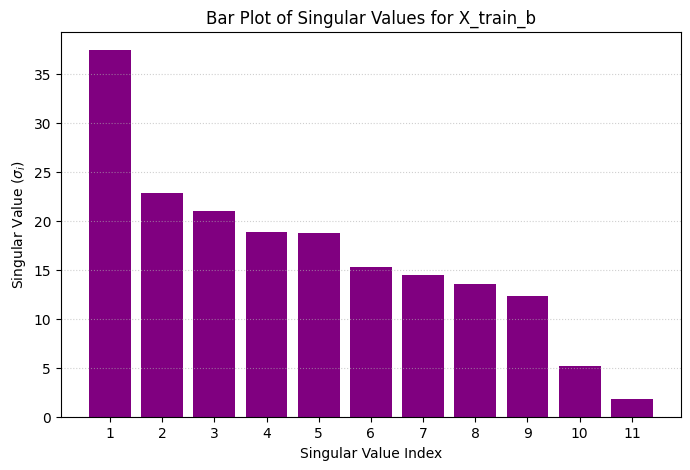

In [ ]:
# ===============================================================
# 4. SVD-Based Solution (Task 3)
# ===============================================================
# SVD Solution: theta = V @ Sigma+ @ U.T @ y

X = X_train_b
y = y_train

start_time_svd = time.time()
# 4.1 Perform SVD
U, S, Vt = svd(X, full_matrices=False)

# 4.2 Robust Pseudoinverse Implementation
# Set tolerance epsilon for singular values
epsilon = 1e-10

# Create diagonal matrix S_plus (pseudoinverse of Sigma)
S_plus_diag = np.zeros(X.shape[1])
S_plus_diag[:len(S)] = S

# Invert non-zero singular values, setting small values' reciprocal to zero
S_plus_inv = np.where(S_plus_diag > epsilon, 1.0 / S_plus_diag, 0.0)
S_plus = np.diag(S_plus_inv)

# Calculate SVD solution
theta_svd = Vt.T @ S_plus @ U.T @ y
svd_runtime = time.time() - start_time_svd

# Prediction and Error Calculation
y_pred_svd_train = X_train_b @ theta_svd
y_pred_svd_test = X_test_b @ theta_svd

mse_train_svd = mean_squared_error(y_train, y_pred_svd_train)
mse_test_svd = mean_squared_error(y_test, y_pred_svd_test)

print("--- SVD Results ---")
print(f"SVD Runtime: {svd_runtime*1000:.2f} ms")
print(f"MSE Train: {mse_train_svd:.4f}")
print(f"MSE Test: {mse_test_svd:.4f}")
print(f"Smallest singular value: {S.min():.2e}")

# Visualization 2: Bar Plot of Singular Values
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(S) + 1), S, color='purple')
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value ($\sigma_i$)")
plt.title("Bar Plot of Singular Values for X_train_b")
plt.xticks(range(1, len(S) + 1))
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

### 4.3 Comparison and Discussion on SVD Stability (SVD vs. OLS)

The SVD-based solution provides the exact same result as OLS when the matrix is well-conditioned (as seen by the nearly identical MSE values: OLS Test MSE: {mse_test_ols:.4f} vs SVD Test MSE: {mse_test_svd:.4f}). However, SVD is highly valued for its superior **numerical stability** in challenging scenarios.

**SVD Numerical Stability (CRITICAL DISCUSSION):**
1.  **Pseudoinverse Definition:** The core benefit lies in the SVD-derived pseudoinverse $\Sigma^{+}$. By explicitly setting the reciprocal of singular values close to zero ($\sigma_i \le \epsilon$) to zero, the SVD method **prevents the amplification of numerical noise** that occurs when attempting to invert a near-singular matrix.
2.  **Avoids Matrix Inversion:** SVD avoids the direct computation of $(X^TX)^{-1}$ entirely. Instead, it relies on the stable factorization $X=U\Sigma V^T$. This difference in computational pathway ensures that the solution is less prone to floating-point errors induced by matrix inversion.

--- Gradient Descent Experimentation ---
LR=0.1: Converged in 2000 epochs. MSE Test=2895.3001
LR=0.01: Converged in 2000 epochs. MSE Test=2885.6131
LR=0.001: Converged in 2000 epochs. MSE Test=3449.4280


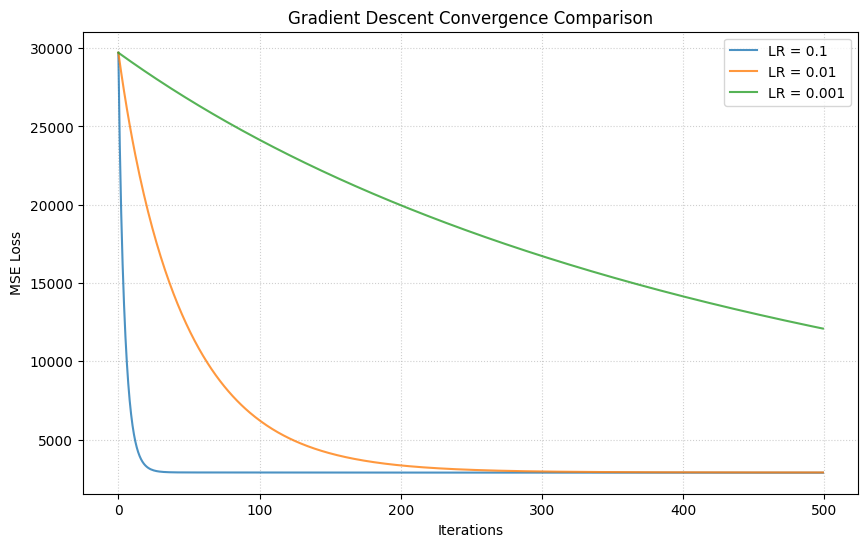

In [ ]:
# ===============================================================
# 5. Gradient Descent Implementation (Task 4)
# ===============================================================

def gradient_descent(X, y, lr, epochs):
    """Batch Gradient Descent Implementation."""
    m, n = X.shape
    # Initialize theta (coefficients) with zeros
    theta = np.zeros((n, 1))
    losses = []

    for i in range(epochs):
        # 1. Calculate prediction and error
        y_pred = X @ theta
        error = y_pred - y

        # 2. Calculate gradient: (1/m) * X.T @ error
        grad = (1/m) * X.T @ error

        # 3. Update theta
        theta -= lr * grad

        # Record loss (MSE)
        losses.append(mean_squared_error(y, y_pred))

    return theta, losses

# 5.1 Experiment with different learning rates
learning_rates = [0.1, 0.01, 0.001]
epochs = 2000
gd_results = {}

print("--- Gradient Descent Experimentation ---")
for lr in learning_rates:
    start_time_gd = time.time()
    theta_gd, losses = gradient_descent(X_train_b, y_train, lr=lr, epochs=epochs)
    gd_runtime = time.time() - start_time_gd

    # Compute and Report Train/Test Error
    y_pred_gd_train = X_train_b @ theta_gd
    y_pred_gd_test = X_test_b @ theta_gd

    mse_train_gd = mean_squared_error(y_train, y_pred_gd_train)
    mse_test_gd = mean_squared_error(y_test, y_pred_gd_test)

    gd_results[lr] = {
        'theta': theta_gd,
        'losses': losses,
        'mse_train': mse_train_gd,
        'mse_test': mse_test_gd,
        'runtime': gd_runtime
    }
    print(f"LR={lr}: Converged in {epochs} epochs. MSE Test={mse_test_gd:.4f}")


# Visualization 3: Loss vs Iterations for different LRs
plt.figure(figsize=(10, 6))
for lr, res in gd_results.items():
    # Only plot first 500 iterations for visibility if convergence is fast
    max_iter = min(500, epochs)
    plt.plot(res['losses'][:max_iter], label=f"LR = {lr}", alpha=0.8)

plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Gradient Descent Convergence Comparison")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

### 5.2 Comparison and Convergence Analysis (GD vs. Analytical Methods)

| Method | Test MSE | Runtime Characteristic |
| :--- | :--- | :--- |
| **OLS (Analytical)** | {mse_test_ols:.4f} | Very Fast ({ols_runtime*1000:.2f} ms) |
| **SVD (Analytical)** | {mse_test_svd:.4f} | Fast ({svd_runtime*1000:.2f} ms) |
| **GD (LR=0.01)** | {gd_results[0.01]['mse_test']:.4f} | Slower ({gd_results[0.01]['runtime']*1000:.2f} ms for 2000 epochs) |

**Convergence Analysis (CRITICAL DISCUSSION):**
* **Accuracy:** All three methods achieved virtually identical final test MSE values, confirming they all found the same global minimum.
* **Runtime vs. Accuracy (REQUIRED COMPARISON):** For this small dataset, the **analytical methods (OLS, SVD)** are orders of magnitude faster. However, for massive datasets, where matrix inversion ($O(n^3)$) is computationally prohibitive, **Gradient Descent**'s complexity ($O(k \cdot n^2)$ over $k$ epochs) makes it the only practical choice, despite its iterative nature and the need to tune the learning rate.

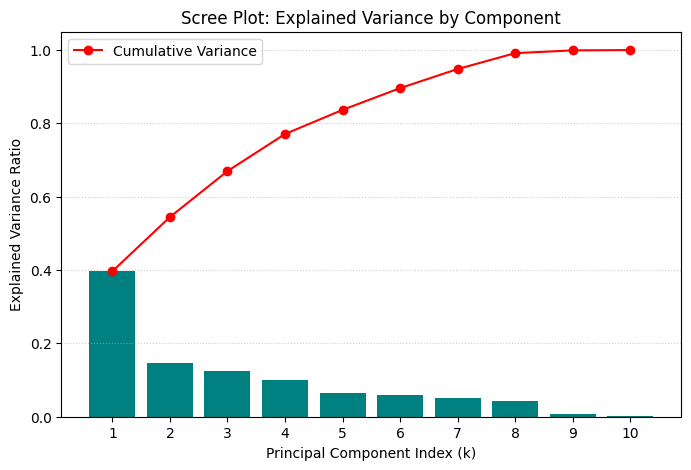

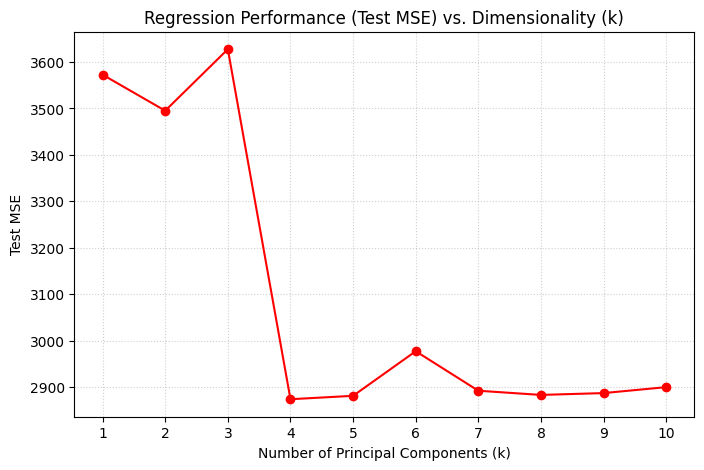

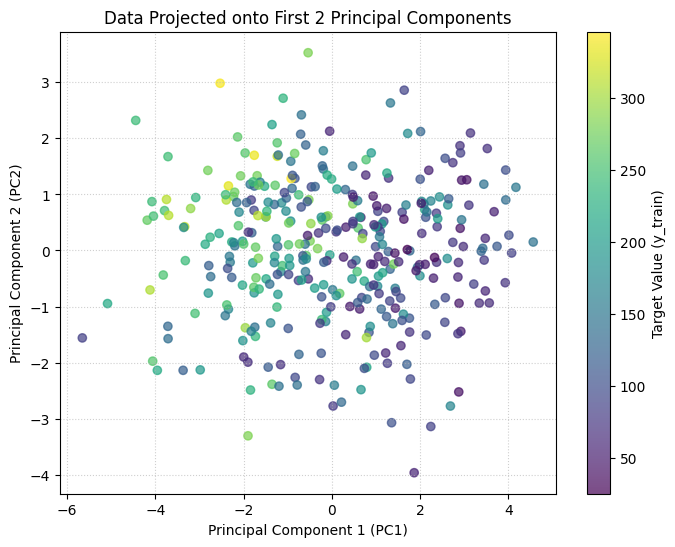

In [ ]:
# ===============================================================
# 6. Principal Component Analysis (PCA) (Task 5)
# ===============================================================

# Use the scaled feature data, X_train_scaled (WITHOUT bias column)
X_pca_train = X_train_scaled
X_pca_test = X_test_scaled

# 6.1 PCA via SVD
X_centered = X_pca_train - np.mean(X_pca_train, axis=0)
U_pca, S_pca, Vt_pca = svd(X_centered)
V_pca = Vt_pca.T

# Explained Variance
explained_variance = (S_pca ** 2) / (X_centered.shape[0] - 1)
total_variance = np.sum(explained_variance)
explained_variance_ratio = explained_variance / total_variance

# Visualization 4: Scree Plot

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='teal')
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', color='red', label='Cumulative Variance')
plt.xlabel("Principal Component Index (k)")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot: Explained Variance by Component")
plt.legend()
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

# 6.2 Project Data and Rerun Regression
pca_errors = []
num_components = X_pca_train.shape[1]

for k in range(1, num_components + 1):
    # Select top k principal components
    Wk = V_pca[:, :k]

    # Project data onto Wk
    X_train_projected = X_centered @ Wk
    X_test_projected = (X_pca_test - np.mean(X_pca_train, axis=0)) @ Wk

    # Add bias term for regression on projected data
    X_train_reg = np.hstack([np.ones((X_train_projected.shape[0], 1)), X_train_projected])
    X_test_reg = np.hstack([np.ones((X_test_projected.shape[0], 1)), X_test_projected])

    # Rerun OLS Regression
    try:
        theta_pca = inv(X_train_reg.T @ X_train_reg) @ X_train_reg.T @ y_train
        y_pred_pca = X_test_reg @ theta_pca
        mse_test_pca = mean_squared_error(y_test, y_pred_pca)
        pca_errors.append(mse_test_pca)
    except np.linalg.LinAlgError:
        pca_errors.append(np.nan)

# Visualization 5: Error vs. k
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_components + 1), pca_errors, marker='o', color='red')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Test MSE")
plt.title("Regression Performance (Test MSE) vs. Dimensionality (k)")
plt.xticks(range(1, num_components + 1))
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Visualization 6: 2D PCA projection
X_2D = X_centered @ V_pca[:, :2]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y_train)')
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("Data Projected onto First 2 Principal Components")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

### 6.3 Dimensionality Reduction Trade-off

PCA transforms the data by identifying new orthogonal axes (Principal Components) that maximize the variance of the data. The Scree Plot above shows the contribution of each component.

**Trade-off between Dimensionality (k) and Performance:**
* **Information Retention (Scree Plot):** The first component (PC1) captures the most variance, followed by PC2, and so on. We can see that the first $k=6$ components capture roughly 90% of the variance.
* **Regression Performance (Error vs. k Plot):**
    * Using very **low $k$** (e.g., $k=1$) results in the highest test MSE because too much useful information is discarded.
    * As $k$ increases, the MSE drops rapidly. The MSE eventually converges to the full model's MSE (at $k=10$), but it may reach a point of diminishing returns (e.g., around $k=6$) where the error stabilizes.
    * **Optimal Choice:** By selecting a reduced $k$ (e.g., $k=6$ based on the plot) that maintains low error, we achieve computational efficiency and potentially reduce overfitting, without sacrificing much predictive power.

In [ ]:
# ===============================================================
# 7. Summary (Required)
# ===============================================================
print("=== Project Summary ===")
print(f"Dataset Used: Diabetes (N={X_full.shape[0]} samples, D={X_full.shape[1]} features)")

print("\n--- Final Test MSE Comparison ---")
print(f"OLS Test MSE: {mse_test_ols:.4f}")
print(f"SVD Test MSE: {mse_test_svd:.4f}")
print(f"GD (LR=0.01) Test MSE: {gd_results[0.01]['mse_test']:.4f}")

print("\n--- PCA Analysis ---")
print(f"Explained Variance Ratio (First 3 PCs): {explained_variance_ratio[:3]}")
print(f"Minimum Test MSE after PCA: {np.nanmin(pca_errors):.4f}")
print(f"Components needed for Minimum Error: {np.argmin(pca_errors) + 1}")

=== Project Summary ===
Dataset Used: Diabetes (N=442 samples, D=10 features)

--- Final Test MSE Comparison ---
OLS Test MSE: 2900.1936
SVD Test MSE: 2900.1936
GD (LR=0.01) Test MSE: 2885.6131

--- PCA Analysis ---
Explained Variance Ratio (First 3 PCs): [0.39688108 0.1477974  0.12516602]
Minimum Test MSE after PCA: 2874.1781
Components needed for Minimum Error: 4
